### Практическое задание к уроку 7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]

In [2]:
first_run=True

In [3]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [14]:
if first_run:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [15]:
if first_run:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip

if first_run:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

first_run=False

## Подготовка датасета для классификации

In [6]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [7]:
random.shuffle(dataset)
len_data=len(dataset)
print(len_data)

599


In [8]:
train_df =dataset[0:int(len_data*0.7)]
val_df = dataset[int(len_data*0.7):int(len_data*0.9)]
test_df= dataset[int(len_data*0.9):]

In [9]:
def prepear_data(f_path):
  data = skvideo.io.vread(f_path)
  data = data.astype(np.float32) / 255.
  return(data)

def get_motion(f_path):
   data=prepear_data(f_path)
   motion = np.mean(data[1:, ...] - data[:-1, ...], axis=3, keepdims=True) 
   return motion

def get_x_y(f_path,label):
     motion=get_motion(f_path)
     x = motion[None, ...]
     y = np.array(label)[None, ...] 
     return x, y


## Визуализация кадра из видео

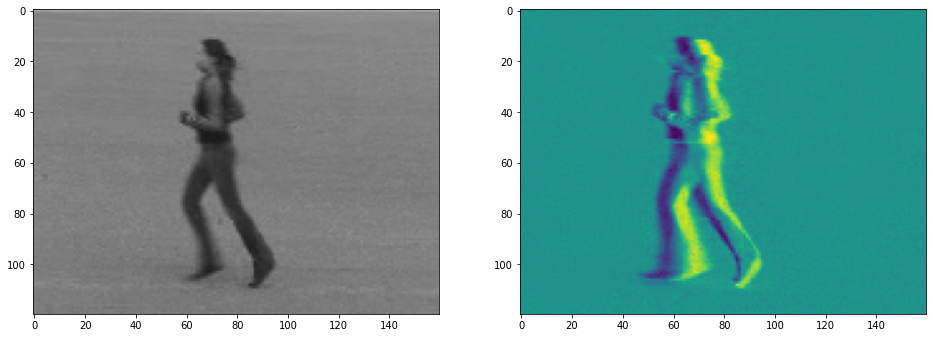

In [226]:
pos=20
fig=plt.figure(figsize=[16,8])
ax=fig.subplots(1,2)
ax[0].imshow(prepear_data(train_df[0][0])[pos])
motion=get_motion(train_df[0][0])
ax[1].imshow(motion[pos, ..., 0])


## Создание модели CNN

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [11]:
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=["sparse_categorical_accuracy"])

writer = tf.summary.create_file_writer('logs/exp1')

In [12]:
def fit_model(model, train, test,global_step):
  train_loss=[]
  val_loss=[]
  for iter, (f_path, label) in enumerate(train):
        x, y=get_x_y(f_path, label)
        loss_value = model.train_on_batch(x, y)
        train_loss.append(loss_value[0])
        if iter % 10 == 0:
            with writer.as_default():
               tf.summary.scalar('loss', loss_value[0], global_step)
               
        global_step += 1
    
  for iter, (f_path, label) in enumerate(test):
        x, y=get_x_y(f_path, label)
        loss_test=model.test_on_batch (x, y)
        val_loss.append(loss_test)
  return  train_loss, val_loss ,global_step



In [13]:
NUM_EPOCHS=10
global_step = 0
for ep in range(NUM_EPOCHS):
    loss_value, loss_test, global_step=fit_model(model,train_df,test_df,global_step)  
    print(f'[{ep}/{NUM_EPOCHS}] Loss = {np.mean(loss_value)}  Val Loss {np.mean(loss_test)}')
        

[0/10] Loss = 1.5381516904874677  Val Loss 0.7955067628994584
[1/10] Loss = 0.884539986535476  Val Loss 0.7601216252912308
[2/10] Loss = 0.5854146794993845  Val Loss 0.6581465847660165
[3/10] Loss = 0.41007820169177317  Val Loss 0.6537712281166438
[4/10] Loss = 0.3176559548794994  Val Loss 0.6145492102259594
[5/10] Loss = 0.25523322909795004  Val Loss 0.5896449025553243
[6/10] Loss = 0.20804928791590085  Val Loss 0.5813799691176759
[7/10] Loss = 0.17922319801922024  Val Loss 0.5818508457233516
[8/10] Loss = 0.21347465415512765  Val Loss 0.6065514121563981
[9/10] Loss = 0.16269102485177336  Val Loss 0.5847637020035388


## Тестирование

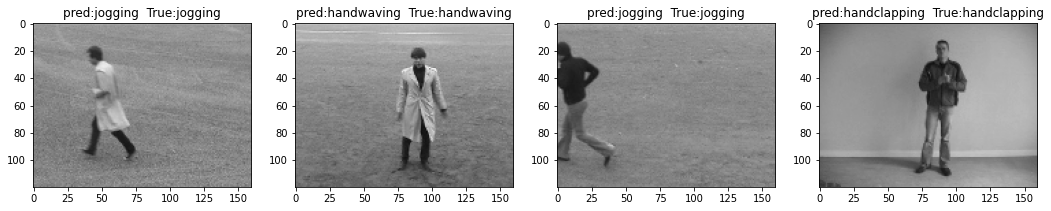

In [35]:
number=4
fig=plt.figure(figsize=[18,8])
ax=fig.subplots(1,number)
for i in range(number):
  
  f_path, cls_true = random.choice(test_df)
  motion = get_motion(f_path)
  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())
  ax[i].imshow(prepear_data(f_path)[40])
  ax[i].set_title(f'pred:{classes[cls_pred]}  True:{classes[cls_true]}')
